In [2]:
import os
import sys
import random
import pandas as pd
import numpy as np
from os.path import join
from tqdm import tqdm
sys.path.append('../include')

from utils import process_annotation, parse_remark_cell, get_labels_start_end_time
from visualize import get_labels, plot_action_list

## Step 0: Set up the directories and variables
- general setup and variable initalization
- remove videos with complicaitons from list

In [14]:

base_dir = r"C:\Users\smuel\Data\2024_SICS_Phase"
video_dir = join(base_dir, "Videos 2")
gt_dir = join(base_dir, 'groundTruth105_c13_nobg')
annotations = pd.read_csv(join(base_dir, "sics_annotation_data3.csv"))
col_id = "Video_ID"
col_files = "OLD_FILE"
FPS = 15

if not os.path.exists(gt_dir):
    os.mkdir(gt_dir)

print(f"Found {len(os.listdir(video_dir))} videos in {os.path.basename(video_dir)}")
print(f"Found {len(annotations)} annotations in sics_annotation_data.csv")

Found 145 videos in Videos 2
Found 126 annotations in sics_annotation_data.csv


In [15]:
## remove videos with complications e.g. vitreoectomy
exclude_videos = ["Difficult cataract 1", "Difficult cataract 2", "Video 15", "Video 37", "Video 38", "video 40", "video 42", "video 43", "video 44",
                "video 45", "Video 47", "Video 48", "video 51", "video 66"]

print(f"Number of videos with complications to be excluded: {len(exclude_videos)}")
annotations = annotations[~annotations['OLD_ID'].isin(exclude_videos)] # Drop rows with excluded videos

# Drop rows with column value higher than outlier_length of x minutes
outlier_length = 21.5
annotations["Duration_surgery"] = annotations["Duration_surgery"].apply(lambda d: int(d.split(":")[0]))
print(f"Number of videos that are too long to be excluded: ", len(annotations[annotations['Duration_surgery'] > outlier_length].index))
annotations = annotations.drop(annotations[annotations['Duration_surgery'] > outlier_length].index)


# check if each row correspondence to a video file in the video directory
for i, row in annotations.iterrows():
    video_file = row[col_files]
    if pd.isna(video_file):
        continue
    video_path = join(video_dir, video_file)
    if not os.path.exists(video_path):
        print(f"Missing video: {video_path}")
        continue

print(f"After exclusion, {len(annotations)} annotations are left")

Number of videos with complications to be excluded: 14
Number of videos that are too long to be excluded:  9
After exclusion, 105 annotations are left


## Step 1: Write class mapping for each annotation phase to file mapping.txt

In [16]:

def generate_mapping(dataframe, start_idx=7):
    mapping = {"background": 0}
    mapping_count = 1
    for col_name in dataframe.columns[start_idx:start_idx+40]:
        #print(f'Class: {col_name}')
        class_name = "_".join(col_name.split('_')[:-1])
        if mapping.get(class_name) is None:
            mapping[class_name] = mapping_count
            mapping_count += 1
    return mapping
        
mapping = generate_mapping(annotations)
with open(join(base_dir, 'mapping.txt'), 'w') as f:
    for key, value in mapping.items():
        f.write(f'{value}: {key}\n')

print("Generated mapping: ", mapping)

Generated mapping:  {'background': 0, 'SR_bridle_suture': 1, 'peritomy': 2, 'cautery': 3, 'scleral_groove': 4, 'incision': 5, 'tunnel': 6, 'sideport': 7, 'AB_injection_and_wash': 8, 'OVD_injection': 9, 'capsulorrhexis': 10, 'main_incision_entry': 11, 'hydroprocedure': 12, 'nucleus_prolapse': 13, 'nucleus_delivery': 14, 'cortical_wash': 15, 'OVD_IOL_insertion': 16, 'OVD_wash': 17, 'stromal_hydration': 18, 'tunnel_suture': 19, 'conjunctival_cautery': 20}


## Step 2: Generate frame-wise annotations for each video and write them to file 

In [17]:
print(f'####### Processing {len(annotations)} annotations #######')
bg_perc = []
for i, row in annotations.iterrows():
    cur_annotation = process_annotation(row, video_dir, mapping, col_name='OLD_FILE', fps=FPS)
    #print(len(anno), np.count_nonzero(anno))
    #print(anno[500:1000])
    
    # sanity check
    class_dict = dict(zip(*np.unique(cur_annotation, return_counts=True)))
    inv_class = {v: k for k, v in mapping.items()}
    class_occurence = {inv_class[k]: v/30.0 for k, v in class_dict.items()}
    background_count, total_count = class_occurence["background"], sum(class_occurence.values())
    bg_perc.append(background_count / total_count)
    #print(f'Percentage of background: {background_count / total_count}, {class_occurence}')
    
    #convert and write to file
    anno_list = [inv_class[elm] for elm in cur_annotation.tolist()]
    with open(join(gt_dir, f'{os.path.splitext(row[col_id])[0]}.txt'), 'w') as f:
        f.write("\n".join(anno_list))
        pass
    
print(f'Average background percentage: {np.mean(bg_perc)}')

####### Processing 105 annotations #######
Average background percentage: 0.39010855491883173


## Step 3: Incoperate additional (structured) remarks into ground truth files

In [18]:

for i, row in annotations.iterrows():
    print('Working on remarks for video: ', row.iloc[0])
    video_id = row.iloc[0]
    
    gt_file = row[col_id] + '.txt'
    if not gt_file or not os.path.exists(join(gt_dir, gt_file)):
        print(f'Ground truth file {gt_file} not found')
        continue
    
    gt_lines = open(join(gt_dir, gt_file), 'r').readlines()
    # if gt_lines[-1] == '': gt_lines = gt_lines[:-1]
    
    for i in range(47, len(row), 2):
        if pd.isna(row.iloc[i]) or pd.isna(row.iloc[i+1]):
            continue
        start, end, cur_class = parse_remark_cell(row.iloc[i], row.iloc[i+1], mapping, fps=FPS)
        if start is None or end is None or cur_class is None:
            continue
        print('Parsed remark: ', start, end, cur_class)
        
        for i in range(start, end):
            gt_lines[i] = cur_class + '\n'
    open(join(gt_dir, gt_file), 'w').writelines(gt_lines)     

Working on remarks for video:  BN_0000
Parsed remark:  1530 1890 scleral_groove
Parsed remark:  1965 2145 incision
Working on remarks for video:  BN_0001
Parsed remark:  6945 7275 main_incision_entry
Working on remarks for video:  BN_0002
Parsed remark:  3210 3270 sideport
Parsed remark:  9855 9930 OVD_injection
Parsed remark:  10035 10590 OVD_IOL_insertion
Working on remarks for video:  BN_0003
Parsed remark:  2025 2085 main_incision_entry
Parsed remark:  16590 16950 cortical_wash
Parsed remark:  17025 17655 stromal_hydration
Parsed remark:  18660 18690 stromal_hydration
Working on remarks for video:  BN_0004
Working on remarks for video:  BN_0005
Working on remarks for video:  BN_0006
Parsed remark:  6450 6870 tunnel_suture
Parsed remark:  9630 9735 main_incision_entry
Working on remarks for video:  BN_0007
Parsed remark:  11385 11550 main_incision_entry
Parsed remark:  13050 13110 sideport
Working on remarks for video:  BN_0008
Parsed remark:  9915 10080 nucleus_delivery
Working on 

## Step 4: Combine certain classes into one class and merge if possible

In [11]:

def reduce_classes_in_gt(actions, combinations, bg='background'):
    flag_combine = False
    start_idx = -1
    last_class = None
    end_idx = -1
    inside_anno = False
    
    # Combine certain actions
    for comb in combinations:
        actions = [comb[0] if action in comb else action for action in actions]

    # Combine actions that are the same and are next to each other
    for idx, action in enumerate(actions):
        cur_class = actions[idx]
        
        if not inside_anno and cur_class != 'background' and cur_class != last_class:
            inside_anno = True
            start_idx = idx
            continue
        elif not inside_anno and cur_class != 'background' and last_class == cur_class:
            inside_anno = True
            flag_combine = True
            continue
        
        if inside_anno and cur_class == 'background' and not flag_combine:
            inside_anno = False
            end_idx = idx - 1
            last_class = actions[end_idx]
        elif inside_anno and cur_class == 'background' and flag_combine:
            flag_combine = False
            inside_anno = False
            end_idx = idx - 1
            last_class = actions[end_idx]
            for i in range(start_idx, end_idx+1):
                actions[i] = last_class
    return actions

combinations = [                                                    
                ['cautery', 'peritomy'], # cm --> yes 
                ['scleral_groove', 'incision', 'tunnel'] # cm --> yes,
                ['hydroprocedure', 'nucleus_prolapse', 'nucleus_delivery'],
                ['stromal_hydration', 'tunnel_suture', 'conjunctival_cautery'], # cm --> yes 
                # ['tunnel_suture', 'conjunctival_cautery'],
                # ['scleral_groove', 'incision'],
                ['background', 'SR_bridle_suture'] # remove SR_bridle_suture due to low occurence
            ]     
labels = get_labels('sics73')

gt_files = os.listdir(gt_dir)
for file in tqdm(gt_files):
    cur_gt = open(join(gt_dir, file), 'r').read().split('\n')
    gt = reduce_classes_in_gt(cur_gt, combinations, bg='background')
    open(join(gt_dir, file), 'w').write("\n".join(gt))


100%|██████████| 105/105 [00:01<00:00, 81.31it/s]


## Step 5 (optional): Remove background inbetween clases
- Extend current class until the beginning of the next class
- Ablation study whether background impacts algorithm performance

In [12]:
def remove_intraclass_bg(actions, idx_end=-1, bg='background'):
    last_action = None 
    for i, action in enumerate(actions):
        if i >= idx_end: # skip last section
            continue
        if last_action == None and action != bg:
            last_action = action
        elif action == bg and last_action != None:
            actions[i] = last_action
        elif action != last_action and action != bg:
            last_action = action
    return actions

gt_files = os.listdir(gt_dir)
for file in tqdm(gt_files):
    cur_gt = open(join(gt_dir, file), 'r').read().split('\n') # Read file
    
    _, start, _ = get_labels_start_end_time(cur_gt)
    cur_gt = remove_intraclass_bg(cur_gt, idx_end=start[-1], bg='background') 
    
    open(join(gt_dir, file), 'w').write("\n".join(cur_gt)) # Write changed file


100%|██████████| 105/105 [00:01<00:00, 99.31it/s]


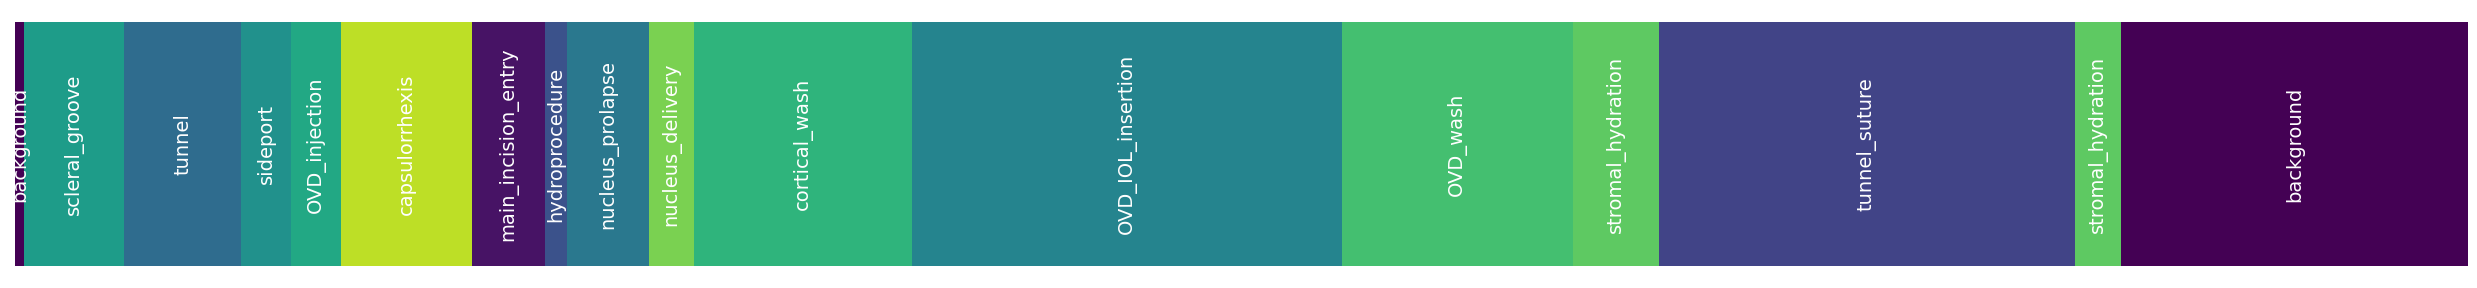

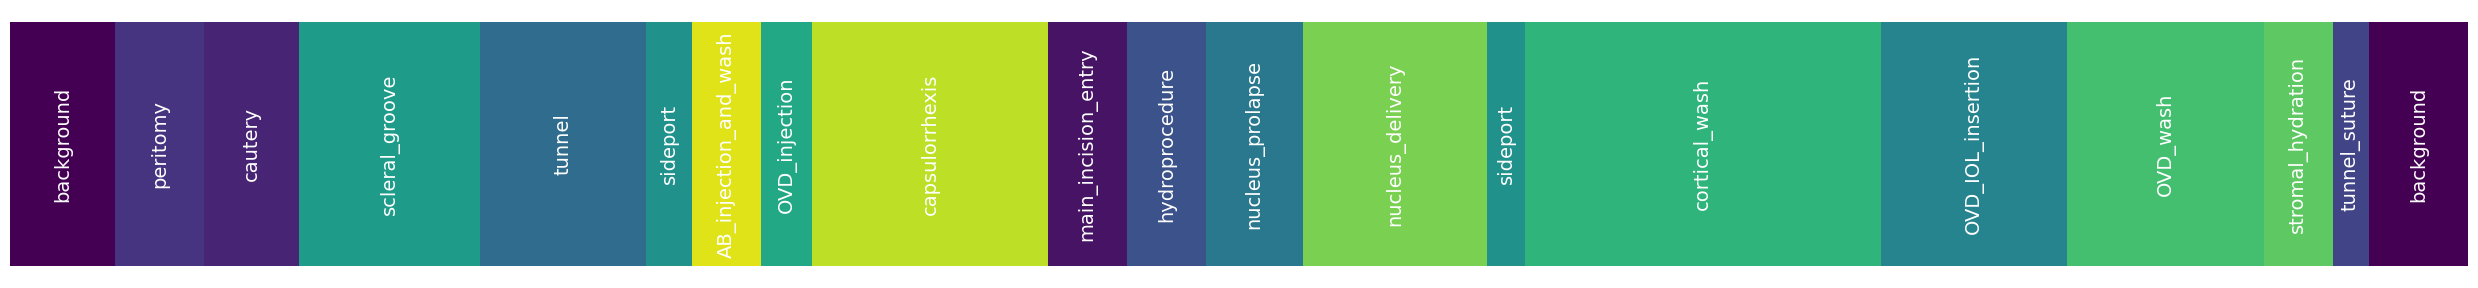

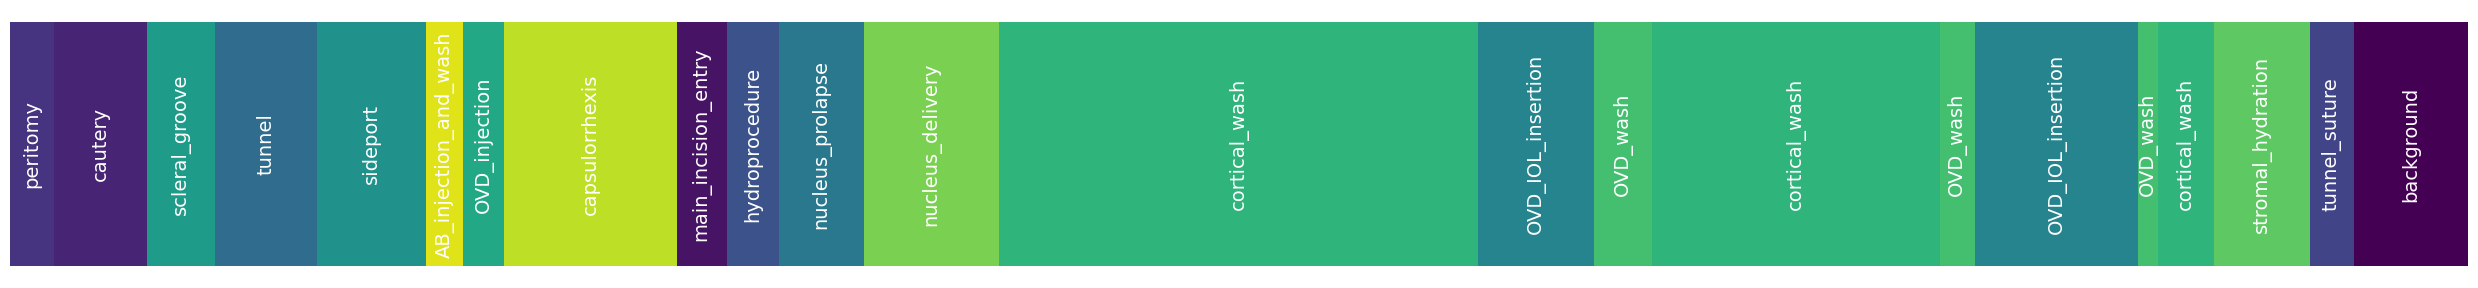

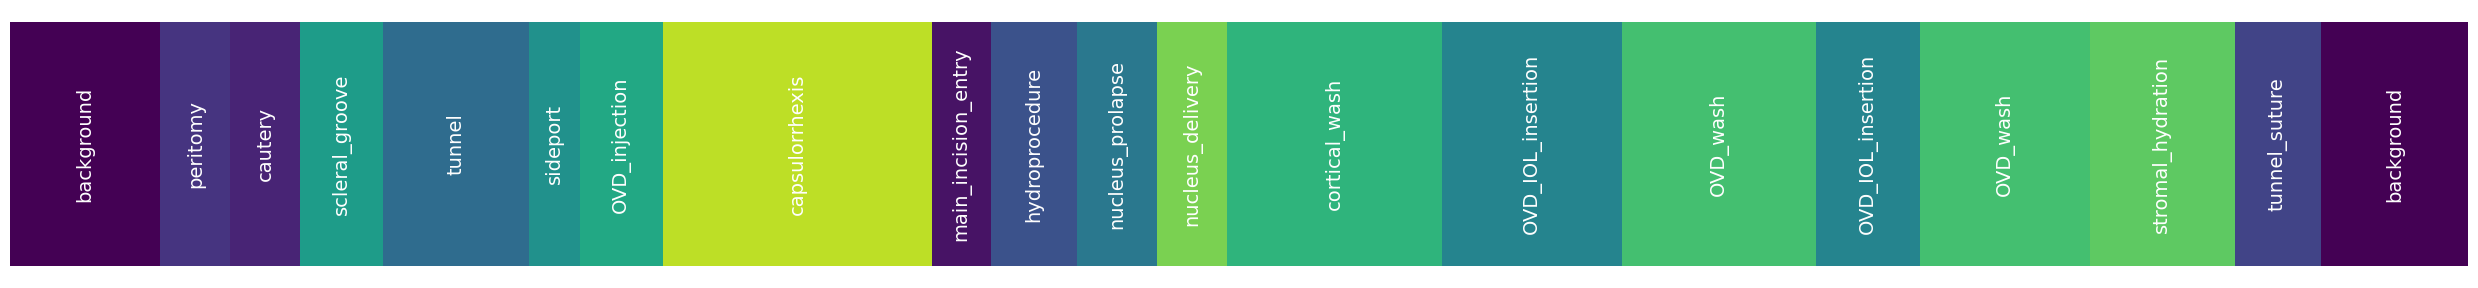

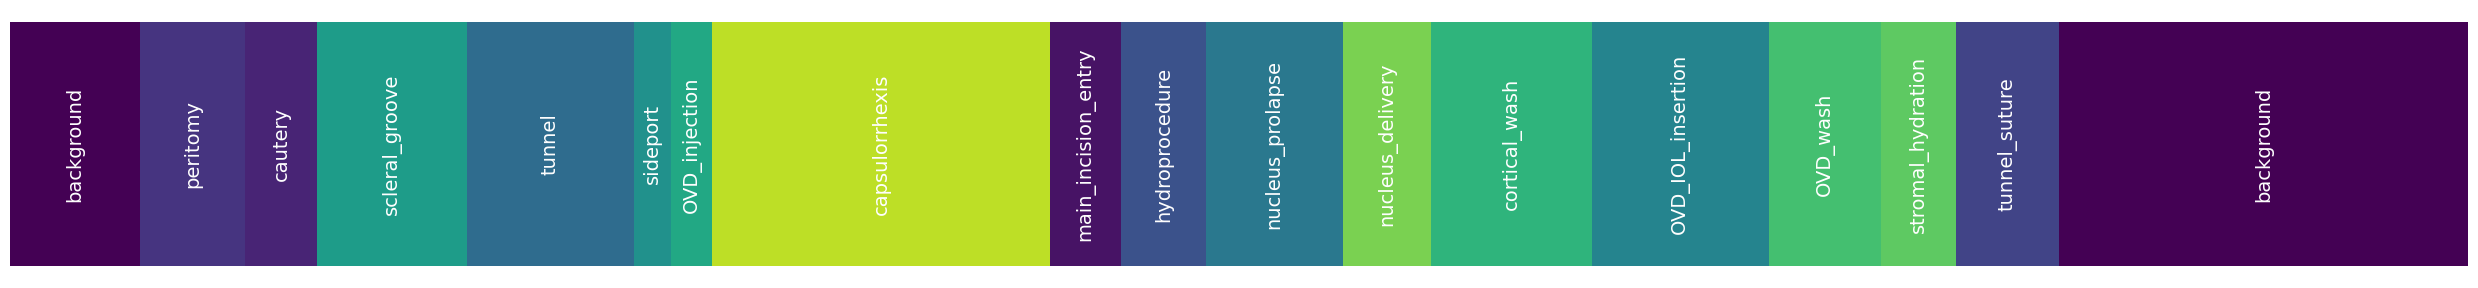

In [13]:
import random
# Plot the first 5 ground truth files
for file in random.sample(gt_files, 5): 
    cur_gt = open(join(gt_dir, file), 'r').read().split('\n')
    #print(list(set(cur_gt)), cur_gt[-1])
    #print(cur_gt[-10:])
    plot_action_list(cur_gt, labels)

In [16]:
# Sanity check on extracted groud truth

gt_files = os.listdir(gt_dir)
selected_files = random.sample(gt_files, 5) # Randomly select 10 files
perform_check = False

for file in selected_files: # Iterate over the selected files
    if not perform_check: break
    
    print(f"Sanity check on gt file: {file}")
    with open(join(gt_dir, file), 'r') as f:
        lines = f.readlines()
        selected_lines = random.sample(list(enumerate(lines)), 10) # Randomly select 10 lines with line numbers
        for line_number, line in selected_lines: # Print the selected lines with line numbers
            print(f"Timestamp: {int((line_number + 1) / FPS)}sec - {int((line_number + 1) / FPS // 60)}:{int((line_number + 1) / FPS % 60):02d}, class {line.strip()}")
    print()
